In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import dtw
import improved_dtw

from data_processing import DataIterator
from models import Autoregression

# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [2]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0, nrows=120000)

## Формат данных
Данные представляют собой зависимость потенциалов в 128 точках мозга обезъяны от времени.   
Показатели снимаются каждую миллисекунду.  

Всего - 3697432 измерений

In [3]:
data_sample = data.loc[100000:100700, :"ECoG_ch6"]

In [4]:
data_sample.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
100000,100.000,51,111,-101,107,-18,118
100001,100.001,63,118,-101,115,13,166
100002,100.002,62,137,-87,143,21,167
100003,100.003,65,146,-61,124,16,201
100004,100.004,94,167,-57,109,89,268


## Визуализация данных
Данные взяты из середины выборки

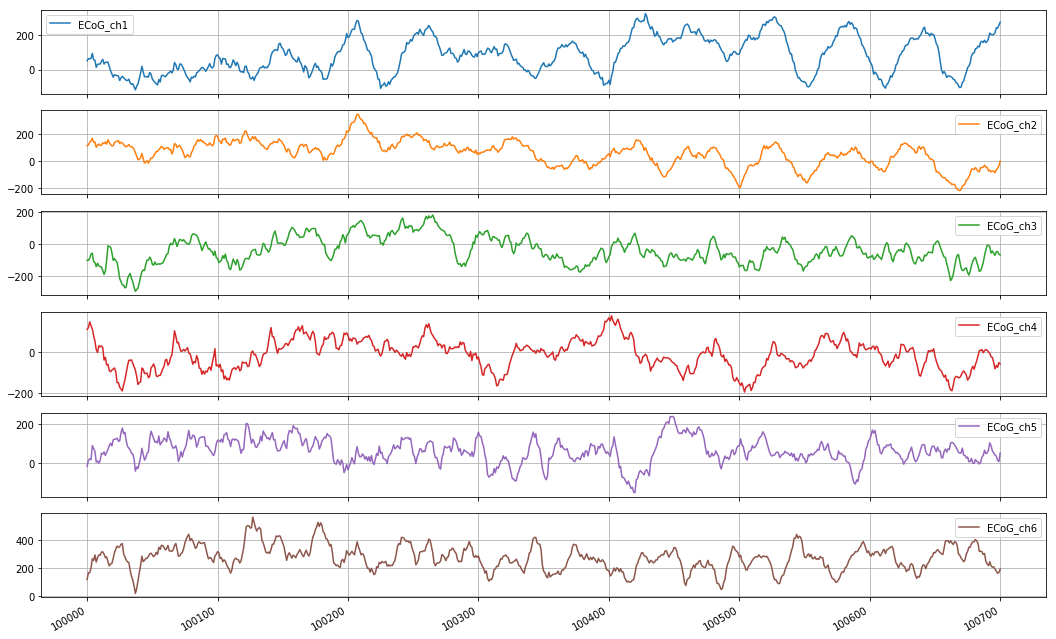

In [5]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 12), grid=True);

## Проведем серию усреднений, чтобы посмотреть на тенденции измерения потенциалов
### Небольшое усреднение по трем, рядом лежащим, точкам

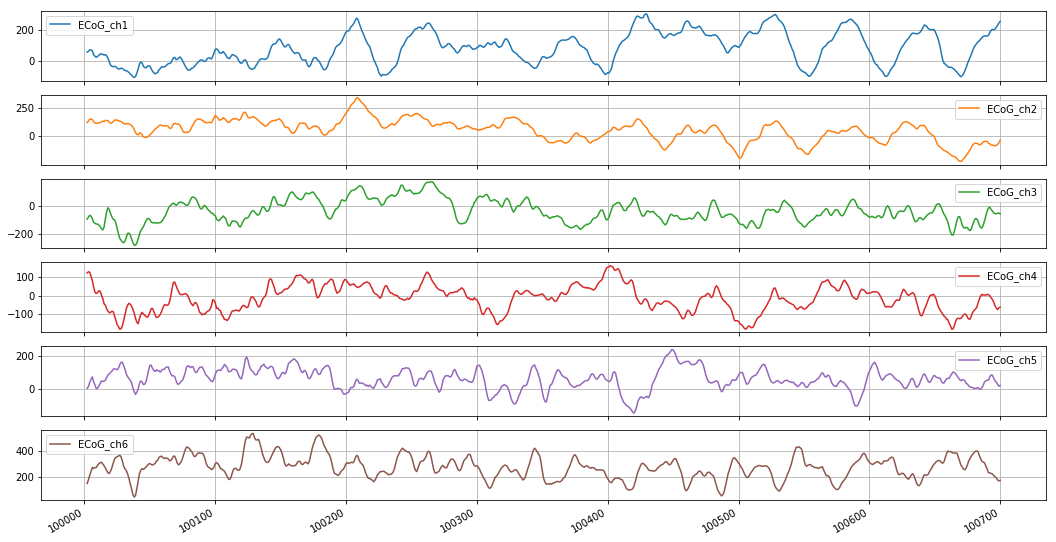

In [6]:
%matplotlib inline
data_sample.rolling(window=3).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Усреднение по 20 точкам

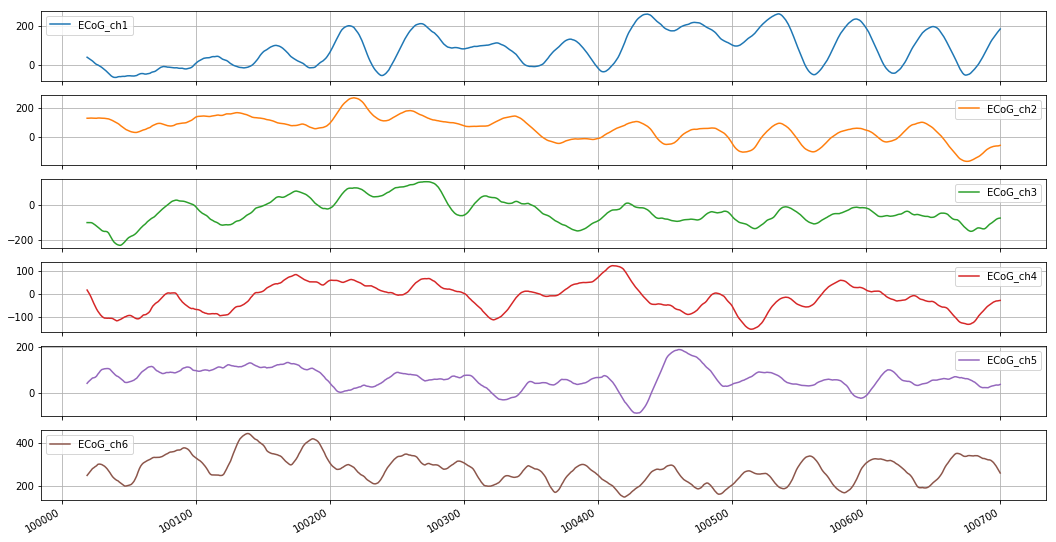

In [7]:
%matplotlib inline
data_sample.rolling(window=20).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Посмотрим на маленький отрезок данных

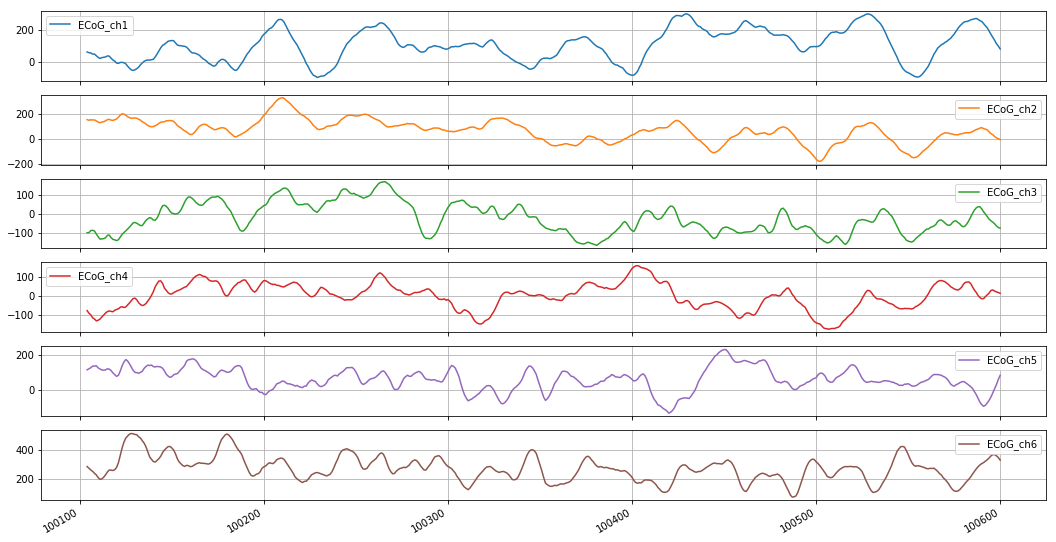

In [8]:
%matplotlib inline
data_sample.loc[100100:100600, "ECoG_ch1":].rolling(window=5).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Для большего количества измерений

In [9]:
data_sample = data.loc[:100000, :"ECoG_ch6"]

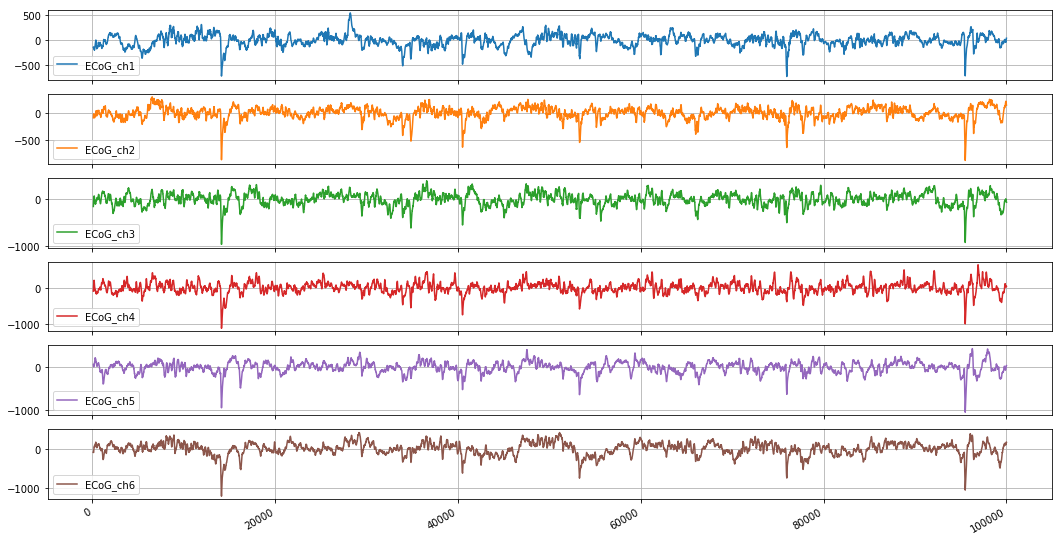

In [10]:
%matplotlib inline
data_sample.rolling(window=100).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Предположение
Можно попробовать два варианта разбиения временных рядом по 100 и по 300 точек.  
Так как в среднем, за этот период ряд претерпевает изменение значений в обе стороны.

In [11]:
#  Итератор для данных, ряды переманны
element_length = 100
data_iter = DataIterator(data_sample, element_length)

In [12]:
item = next(data_iter)

In [13]:
item.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
56600,56.600,165,106,174,60,-175,-112
56601,56.601,160,112,173,69,-161,-69
56602,56.602,154,122,162,98,-180,-44
56603,56.603,148,115,124,78,-148,-36
56604,56.604,136,95,89,75,-131,-54


## Эксперимент с DTW для первого измерения

In [14]:
x = next(data_iter).loc[:, "ECoG_ch1"]
y = next(data_iter).loc[:, "ECoG_ch1"]

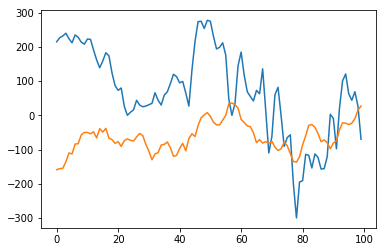

In [15]:
%matplotlib inline
time = np.linspace(0, element_length - 1, element_length)
plt.plot(time, x)
plt.plot(time, y)

In [16]:
def one_dimension_dtw(x, y):
    return dtw.dtw(x.values.reshape(-1, 1), y.values.reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [17]:
dist, cost, acc, path = one_dimension_dtw(x, y)

Distance: 67.845


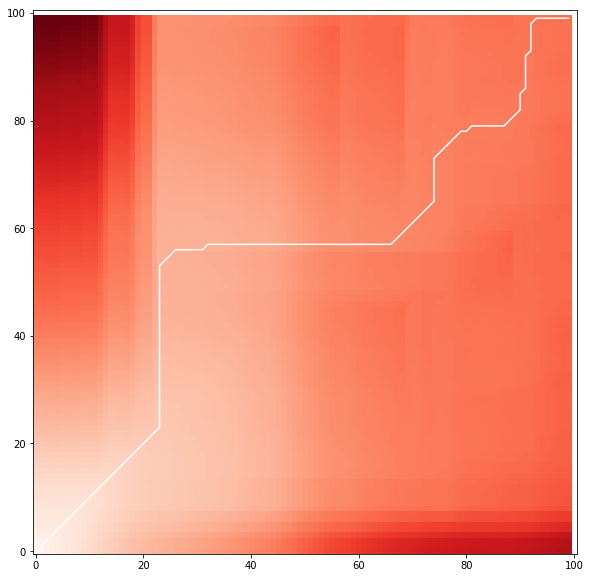

In [18]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

# Эксперимент с авторегрессионной моделью

In [117]:
import torch

In [118]:
window_size = 10
ar = Autoregression(item.loc[:, :"ECoG_ch5"], window_size)

In [119]:
ar.fit(10)

Loss: 213887.500
Loss: 14095.771
Loss: 12613.094
Loss: 12023.620
Loss: 11637.946
Loss: 11370.554
Loss: 11182.493
Loss: 11048.873
Loss: 10953.066
Loss: 10883.713
Loss: 10833.065
Loss: 10795.766
Loss: 10768.068
Loss: 10747.344
Loss: 10731.715


In [120]:
predicted = ar.predicted_series()
x = ar.data.loc[:, "ECoG_ch1" : "ECoG_ch5"].values

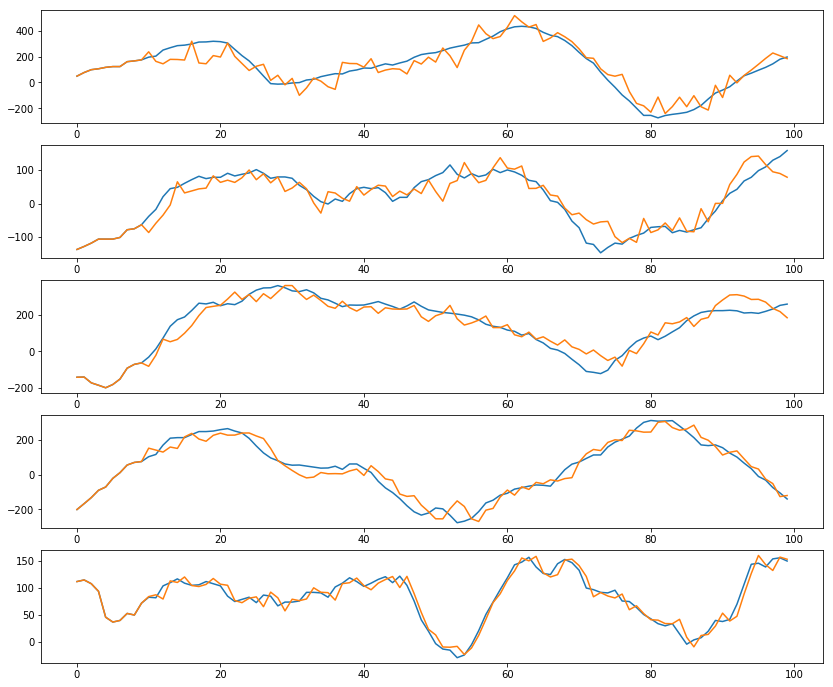

In [121]:
plt.figure(figsize=(14, 12))
time = np.linspace(0, element_length - 1, element_length)

for (i, pred) in enumerate(predicted):
    
    plt.subplot(len(predicted), 1, i+1)
    plt.plot(time, x[:,i])
    plt.plot(time, pred)

plt.show()

# Эксперименты с многомерным DTW

In [19]:
from dtw import dtw as dtw_custom

In [25]:
x = next(data_iter)
y = next(data_iter)

In [26]:
x = x.loc[:, "ECoG_ch1":"ECoG_ch3"].values
y = y.loc[:, "ECoG_ch1":"ECoG_ch3"].values

Заметим, что достаточно передать функцию, которая определяет расстояния между векторами

In [27]:
distance = lambda x, y: np.linalg.norm(x - y)

In [28]:
%time
dist, cost, acc, path = dtw_custom(x, y, distance)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


Distance: 139.807


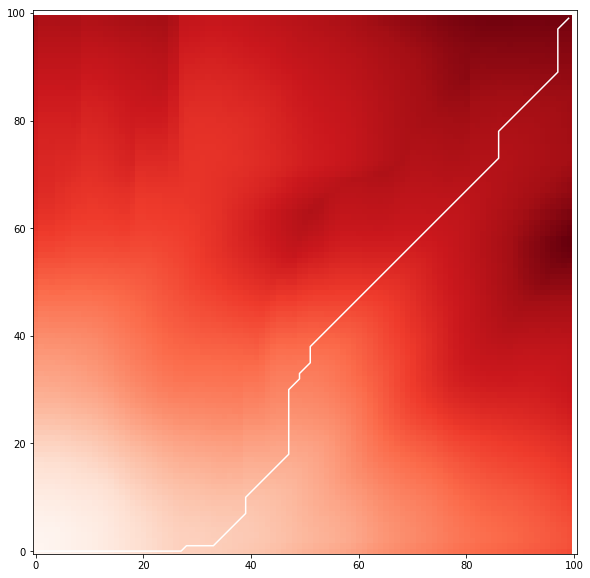

In [29]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

## Различные нормы

### Cosine

In [30]:
from scipy.spatial import distance

In [31]:
%time
dist, cost, acc, path = dtw.dtw_ln(x, y, distance.cosine)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


Distance: 0.400


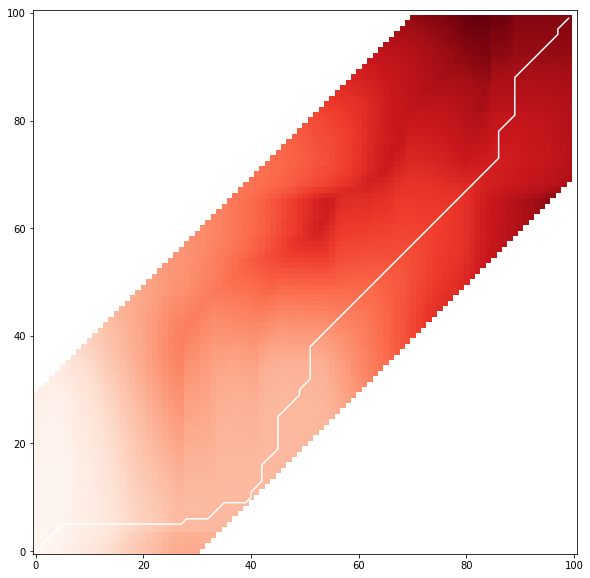

In [32]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

## Иерархическая кластеризация

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [43]:
from improved_dtw import dtw_improved

In [49]:
shape = next(data_iter).loc[:, "ECoG_ch1":"ECoG_ch3"].values.shape

In [56]:
dtw_dist = lambda x, y: (dtw.dtw_ln(x.reshape(shape), y.reshape(shape), distance.chebyshev)[0])
next_prepared = lambda it: next(it).loc[:, "ECoG_ch1":"ECoG_ch3"].values.reshape(1, -1)[0]

In [57]:
X = [next(data_iter) for i in range(40)]
X_reshaped = np.array([x.loc[:, "ECoG_ch1":"ECoG_ch3"].values.reshape(1, -1)[0] for x in X])

In [58]:
%time Z = linkage(X_reshaped, metric=dtw_dist)

CPU times: user 28.8 s, sys: 112 ms, total: 28.9 s
Wall time: 29 s


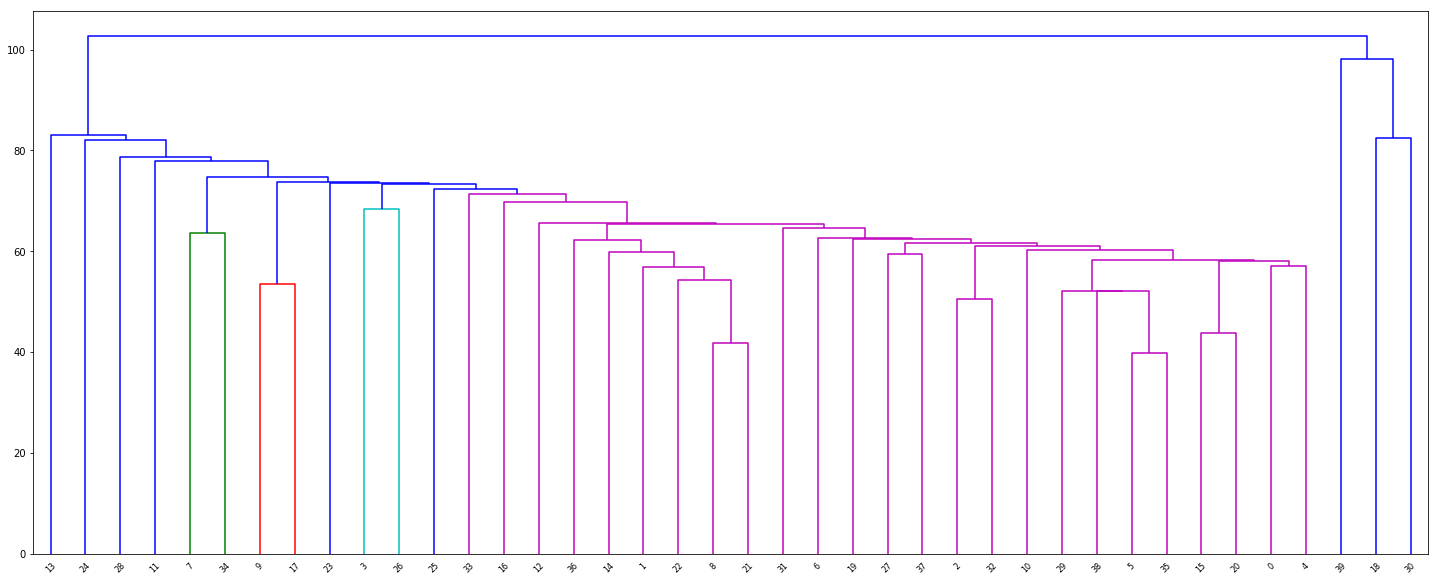

In [59]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [44]:
ar_models = []
for series in X:
    ar = Autoregression(item.loc[:, :"ECoG_ch3"], window_size)
    ar.fit(10)
    ar_models.append(ar.coeffecients())

Loss: 42344.750
Loss: 2718.554
Loss: 2653.444
Loss: 2646.304
Loss: 2645.441
Loss: 2645.327
Loss: 2645.311
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 38059.191
Loss: 2672.318
Loss: 2647.112
Loss: 2645.477
Loss: 2645.329
Loss: 2645.311
Loss: 2645.309
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 40923.242
Loss: 2670.272
Loss: 2647.031
Loss: 2645.485
Loss: 2645.332
Loss: 2645.312
Loss: 2645.309
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 59602.359
Loss: 2672.207
Loss: 2647.388
Loss: 2645.557
Loss: 2645.347
Loss: 2645.315
Loss: 2645.309
Loss: 2645.309
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 2645.308
Loss: 26003.590
Loss: 2730.285
Loss: 2654.187
Loss: 2646.338
Loss: 2645.437
Loss: 2645.325
Loss: